In [15]:
import time
import pandas as pd
import numpy as np
import re
import random
from pprint import pprint
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from clustering.sbd import sbd
from clustering.sbd import silhouette_score
from kshape.core import kshape, zscore
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

## Parameters ###################################################
DATA_FILE = "../data/20200831_user-db_cpu-load_02.json"
TARGET_DATA = {"containers": "all",
               "services": "all",
               "nodes": "all",
               "middlewares": "all"}
PLOTS_NUM = 360
SIGNIFICANCE_LEVEL = 0.05
THRESHOLD_DIST = 0.01
#################################################################

# Prepare data matrix
raw_data = pd.read_json(DATA_FILE)
data_df = pd.DataFrame()
for target in TARGET_DATA:
    for t in raw_data[target].dropna():
        for metric in t:
            if metric["metric_name"] in TARGET_DATA[target] or TARGET_DATA[target] == "all":
                metric_name = metric["metric_name"].replace("container_", "").replace("node_", "")
                target_name = metric["{}_name".format(target[:-1]) if target != "middlewares" else "container_name"].replace("gke-microservices-experi-default-pool-", "")
                if re.match("^gke-microservices-experi", target_name):
                    continue
                column_name = "{}-{}_{}".format(target[0], target_name, metric_name)
                data_df[column_name] = np.array(metric["values"], dtype=np.float)[:, 1][:PLOTS_NUM]
data_df = data_df.round(4)

# Prepare target list
containers_list = []
services_list = []
nodes_list = []
middlewares_list = []
for col in data_df.columns:
    if re.match("^c-", col):
        container_name = col.split("_")[0].replace("c-", "")
        if container_name not in containers_list:
            containers_list.append(container_name)
    elif re.match("^s-", col):
        service_name = col.split("_")[0].replace("s-", "")
        if service_name not in services_list:
            services_list.append(service_name)
    elif re.match("^n-", col):
        node_name = col.split("_")[0].replace("n-", "")
        if node_name not in nodes_list:
            nodes_list.append(node_name)
    elif re.match("^m-", col):
        middleware_name = col.split("_")[0].replace("m-", "")
        if middleware_name not in middlewares_list:
            middlewares_list.append(middleware_name)
            
# Aggregate the dimension of a metric
metrics_dimension = {}
for target in TARGET_DATA:
    metrics_dimension[target] = {}

def count_metrics(metrics_dimension, dataframe, n):
    for col in dataframe.columns:
        if re.match("^c-", col):
            container_name = col.split("_")[0].replace("c-", "")   
            if container_name not in metrics_dimension["containers"]:
                metrics_dimension["containers"][container_name] = [0,0,0]        
            metrics_dimension["containers"][container_name][n] += 1
        elif re.match("^m-", col):
            middleware_name = col.split("_")[0].replace("m-", "")    
            if middleware_name not in metrics_dimension["middlewares"]:
                metrics_dimension["middlewares"][middleware_name] = [0,0,0]
            metrics_dimension["middlewares"][middleware_name][n] += 1
        elif re.match("^s-", col):
            service_name = col.split("_")[0].replace("s-", "")
            if service_name not in metrics_dimension["services"]:
                metrics_dimension["services"][service_name] = [0,0,0]
            metrics_dimension["services"][service_name][n] += 1
        elif re.match("^n-", col):
            node_name = col.split("_")[0].replace("n-", "")
            if node_name not in metrics_dimension["nodes"]:
                metrics_dimension["nodes"][node_name] = [0,0,0]
            metrics_dimension["nodes"][node_name][n] += 1
    return metrics_dimension

metrics_dimension = count_metrics(metrics_dimension, data_df, 0)
metrics_dimension["total"] = [len(data_df.columns)]
pprint(metrics_dimension)

{'containers': {'carts': [55, 0, 0],
                'carts-db': [55, 0, 0],
                'catalogue': [55, 0, 0],
                'catalogue-db': [51, 0, 0],
                'front-end': [55, 0, 0],
                'orders': [55, 0, 0],
                'orders-db': [55, 0, 0],
                'payment': [55, 0, 0],
                'queue-master': [55, 0, 0],
                'rabbitmq': [51, 0, 0],
                'session-db': [51, 0, 0],
                'shipping': [55, 0, 0],
                'user': [55, 0, 0],
                'user-db': [55, 0, 0]},
 'middlewares': {'carts-db': [124, 0, 0],
                 'catalogue-db': [555, 0, 0],
                 'orders-db': [124, 0, 0],
                 'session-db': [136, 0, 0],
                 'user-db': [127, 0, 0]},
 'nodes': {'f8c36136-7m2h': [264, 0, 0],
           'f8c36136-c153': [264, 0, 0],
           'f8c36136-fz8b': [264, 0, 0],
           'f8c36136-qb8m': [264, 0, 0]},
 'services': {'carts': [2, 0, 0],
              'catalo

In [16]:
# Reduce metrics
## Step 1: Reduced metrics by CV
start = time.time()
reduced_by_cv_df = pd.DataFrame()
for col in data_df.columns:
    data = data_df[col].values
    mean = data.mean()
    std =  data.std()
    if mean == 0. and std == 0.:
        cv = 0
    else:
        cv = std / mean
    if cv > 0.002:
        reduced_by_cv_df[col] = data_df[col]

metrics_dimension = count_metrics(metrics_dimension, reduced_by_cv_df, 1)
metrics_dimension["total"].append(len(reduced_by_cv_df.columns))
print("Elapsed time:{:.3f}".format(time.time() - start) + "/sec")
pprint(metrics_dimension)

Elapsed time:0.617/sec
{'containers': {'carts': [55, 12, 0],
                'carts-db': [55, 18, 0],
                'catalogue': [55, 11, 0],
                'catalogue-db': [51, 8, 0],
                'front-end': [55, 15, 0],
                'orders': [55, 13, 0],
                'orders-db': [55, 14, 0],
                'payment': [55, 10, 0],
                'queue-master': [55, 11, 0],
                'rabbitmq': [51, 9, 0],
                'session-db': [51, 4, 0],
                'shipping': [55, 11, 0],
                'user': [55, 15, 0],
                'user-db': [55, 19, 0]},
 'middlewares': {'carts-db': [124, 48, 0],
                 'catalogue-db': [555, 32, 0],
                 'orders-db': [124, 47, 0],
                 'session-db': [136, 53, 0],
                 'user-db': [127, 38, 0]},
 'nodes': {'f8c36136-7m2h': [264, 67, 0],
           'f8c36136-c153': [264, 70, 0],
           'f8c36136-fz8b': [264, 74, 0],
           'f8c36136-qb8m': [264, 74, 0]},
 'services':

In [ ]:
## Step 2: Reduced by k-Shape
def kshape_clustering(target_df, clustering_info, dist_func):
    data = target_df.values.T
    ts_dataset = to_time_series_dataset(data)
    ts_dataset = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(ts_dataset)
    labels = []
    scores = []
    centroids = []
    for n in np.arange(2, ts_dataset.shape[0]):
        ks = KShape(n_clusters=n, max_iter=100, n_init=1)
        ks.fit(ts_dataset)
        labels.append(ks.labels_) 
        scores.append(silhouette_score(data, ks.labels_))
        centroids.append(ks.cluster_centers_)
    idx = np.argmax(scores)
    label = labels[idx]
    centroid = centroids[idx]
    n_cluster = len(np.unique(label))
    cluster_dict = {}
    remove_list = []
    for i, v in enumerate(label):
        if v not in cluster_dict:
            cluster_dict[v] = [i]
        else:
            cluster_dict[v].append(i)
    for c in cluster_dict:
        cluster_metrics = cluster_dict[c]
        if len(cluster_metrics) == 1:
            continue
        if len(cluster_metrics) == 2:
            # Select the representative metric at random
            shuffle_list = random.sample(cluster_metrics, len(cluster_metrics))
            clustering_info[target_df.columns[shuffle_list[0]]] = [target_df.columns[shuffle_list[1]]]
            remove_list.append(target_df.columns[shuffle_list[1]])
        elif len(cluster_metrics) > 2:
            # Select the representative metric based on the distance from the centroid
            distances = []
            cent = centroid[np.where(np.sort(np.unique(label)) == c)[0][0]].T[0]
            for met in cluster_metrics:
                distances.append(sbd(cent, data[met]))
            representative_metric = cluster_metrics[np.argmin(distances)]
            clustering_info[target_df.columns[representative_metric]] = []
            for r in cluster_metrics:
                if r != representative_metric:
                    remove_list.append(target_df.columns[r])
                    clustering_info[target_df.columns[representative_metric]].append(target_df.columns[r])
    return clustering_info, remove_list

start = time.time()
clustering_info = {}
reduced_df = reduced_by_cv_df

# Clustering metrics by services including services, containers and middlewares
for ser in services_list:
    target_df = reduced_by_cv_df.loc[:, reduced_by_cv_df.columns.str.startswith(("s-{}_".format(ser), "c-{}".format(ser), "m-{}".format(ser)))]
    if len(target_df.columns) in [0, 1]:
        continue
    clustering_info, remove_list = kshape_clustering(target_df, clustering_info, sbd)
    for r in remove_list:
        reduced_df = reduced_df.drop(r, axis=1)
    break

# Clustering metrics by nodes
for node in nodes_list:
    node_df = reduced_by_cv_df.loc[:, reduced_by_cv_df.columns.str.startswith("n-{}_".format(node))]
    if len(node_df.columns) in [0, 1]:
        continue
    clustering_info, remove_list = kshape_clustering(node_df, clustering_info, sbd)
    for r in remove_list:
        reduced_df = reduced_df.drop(r, axis=1)    

metrics_dimension = count_metrics(metrics_dimension, reduced_df, 2)
metrics_dimension["total"].append(len(reduced_df.columns))
print("Elapsed time:{:.3f}".format(time.time() - start) + "/sec")
pprint(metrics_dimension)

In [14]:
clustering_info

{'c-shipping_cpu_system_seconds_total': ['c-shipping_cpu_user_seconds_total',
  'c-shipping_cpu_usage_seconds_total',
  'c-shipping_cpu_cfs_periods_total'],
 'c-shipping_memory_cache': ['c-shipping_fs_usage_bytes'],
 'c-shipping_network_receive_packets_total': ['c-shipping_network_transmit_bytes_total',
  'c-shipping_network_transmit_packets_total',
  'c-shipping_network_receive_bytes_total']}

# 可視化

In [89]:
# 正規化
normalized_df = pd.DataFrame()
for column in data_df.columns:
    data = data_df[column].values
    norm_const = data.mean()
    #norm_const = data.max()
    if norm_const == 0. :
        continue    
    normalized_df[column] = data_df[column] / norm_const

In [90]:
normalized_df

,c-carts_cpu_cfs_throttled_seconds_total,c-carts_network_transmit_bytes_total,c-carts_network_receive_bytes_total,c-carts_memory_max_usage_bytes,c-carts_spec_cpu_period,c-carts_fs_inodes_total,c-carts_memory_mapped_file,c-carts_cpu_cfs_throttled_periods_total,c-carts_fs_usage_bytes,c-carts_last_seen,...,m-user-db_mongodb_mongod_wiredtiger_log_operations_total,m-user-db_go_threads,m-user-db_mongodb_network_bytes_total,m-user-db_mongodb_version_info,m-user-db_mongodb_mongod_wiredtiger_cache_bytes,m-user-db_go_memstats_heap_inuse_bytes,m-user-db_promhttp_metric_handler_requests_total,m-user-db_mongodb_up,m-user-db_mongodb_mongod_wiredtiger_transactions_checkpoint_milliseconds_total,m-user-db_mongodb_mongod_wiredtiger_cache_overhead_percent
0,0.000000,1.072923,1.043997,1.0,1.0,1.0,1.0,0.000000,1.046185,0.999999,...,1.003155,1.0,0.995404,1.0,1.0,1.151294,0.999997,1.0,0.000000,1.0
1,0.000000,0.834639,0.808253,1.0,1.0,1.0,1.0,0.000000,1.046185,0.999999,...,1.003175,1.0,0.978092,1.0,1.0,1.049589,0.999997,1.0,1.341710,1.0
2,0.000000,1.024943,0.989109,1.0,1.0,1.0,1.0,0.000000,1.046185,0.999999,...,1.000948,1.0,0.959174,1.0,1.0,1.114680,0.999997,1.0,1.341710,1.0
3,0.000000,1.027874,1.001570,1.0,1.0,1.0,1.0,0.000000,1.046185,0.999999,...,1.000968,1.0,0.979191,1.0,1.0,0.787192,0.999997,1.0,1.341710,1.0
4,2.055336,1.032243,0.998416,1.0,1.0,1.0,1.0,2.478024,1.048267,0.999999,...,1.000948,1.0,0.968347,1.0,1.0,0.872624,0.999997,1.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.422925,1.087136,1.055039,1.0,1.0,1.0,1.0,2.332915,0.980374,1.000001,...,1.000948,1.0,1.003345,1.0,1.0,0.789226,0.999997,1.0,1.174185,1.0
236,2.687747,1.040576,1.012421,1.0,1.0,1.0,1.0,4.185852,0.980374,1.000001,...,1.003155,1.0,0.988608,1.0,1.0,1.065862,0.999997,1.0,0.000000,1.0
237,1.422925,0.986546,0.974129,1.0,1.0,1.0,1.0,2.243617,0.980374,1.000001,...,0.936294,1.0,0.934140,1.0,1.0,1.143157,0.999997,1.0,1.341710,1.0
238,1.581028,0.935551,0.915958,1.0,1.0,1.0,1.0,2.511511,0.980374,1.000001,...,0.871649,1.0,0.893148,1.0,1.0,0.836010,0.999997,1.0,1.341710,1.0


/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


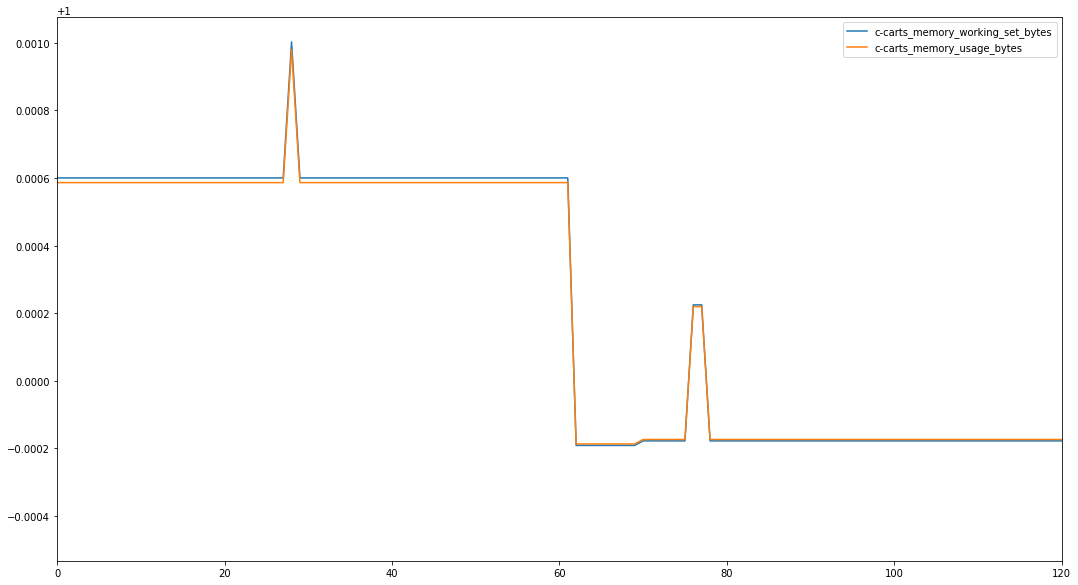

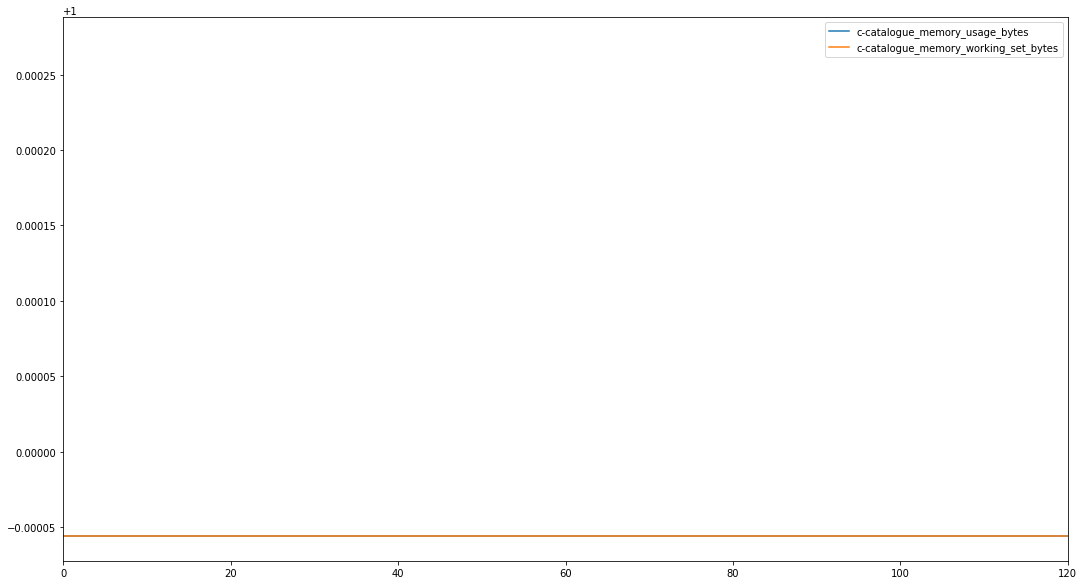

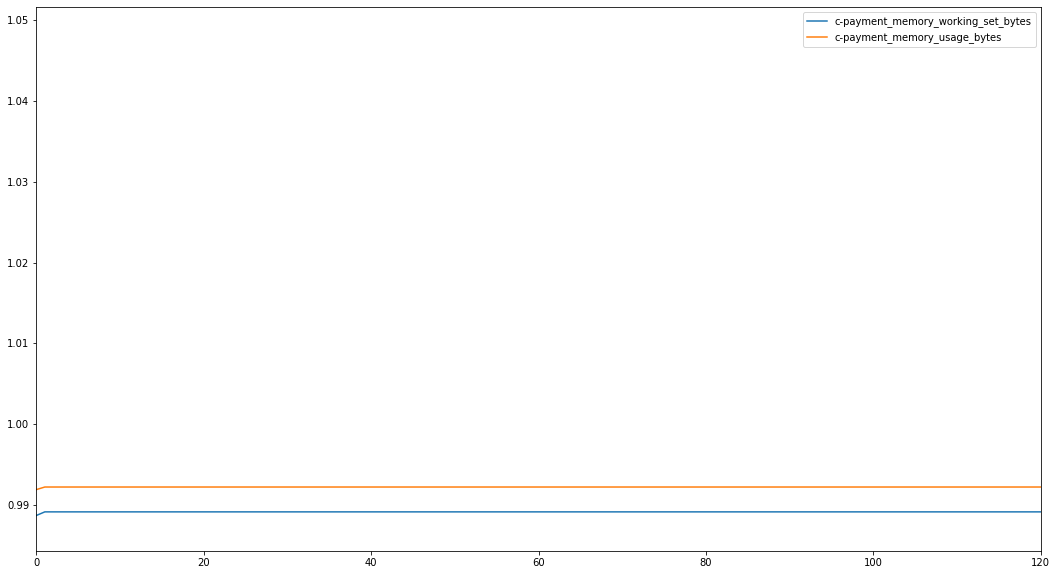

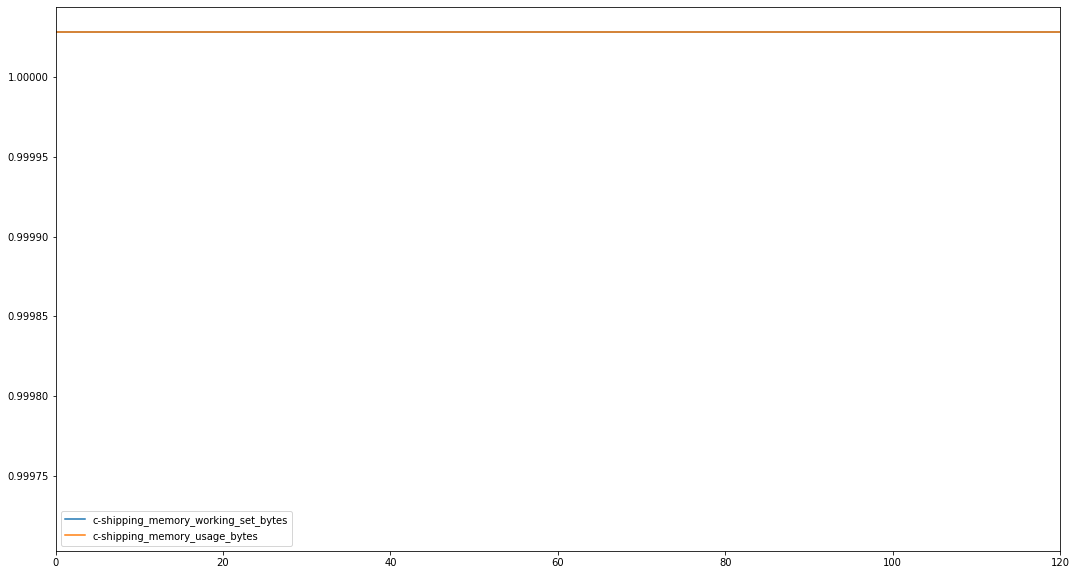

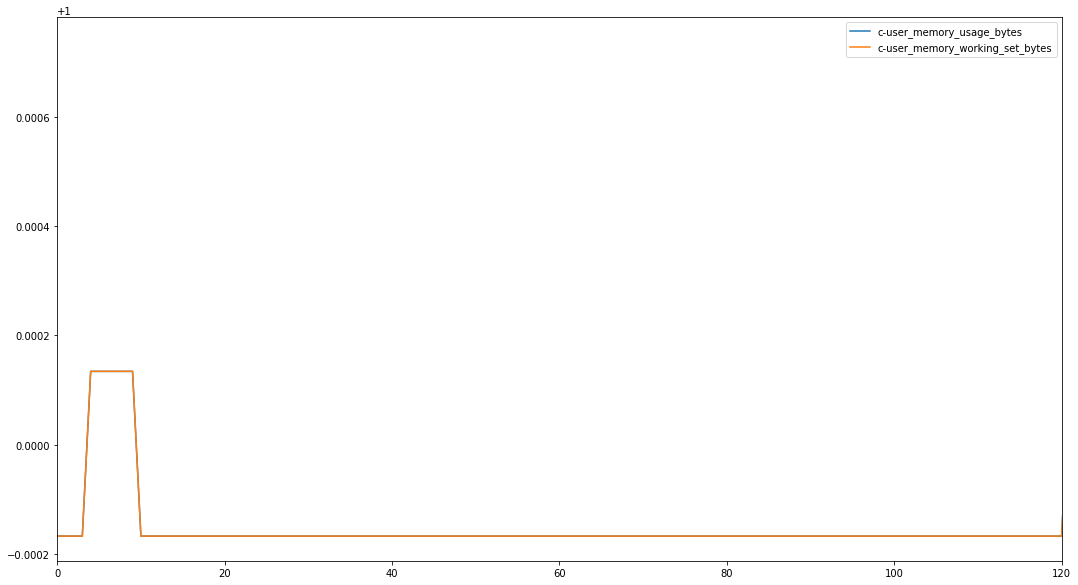

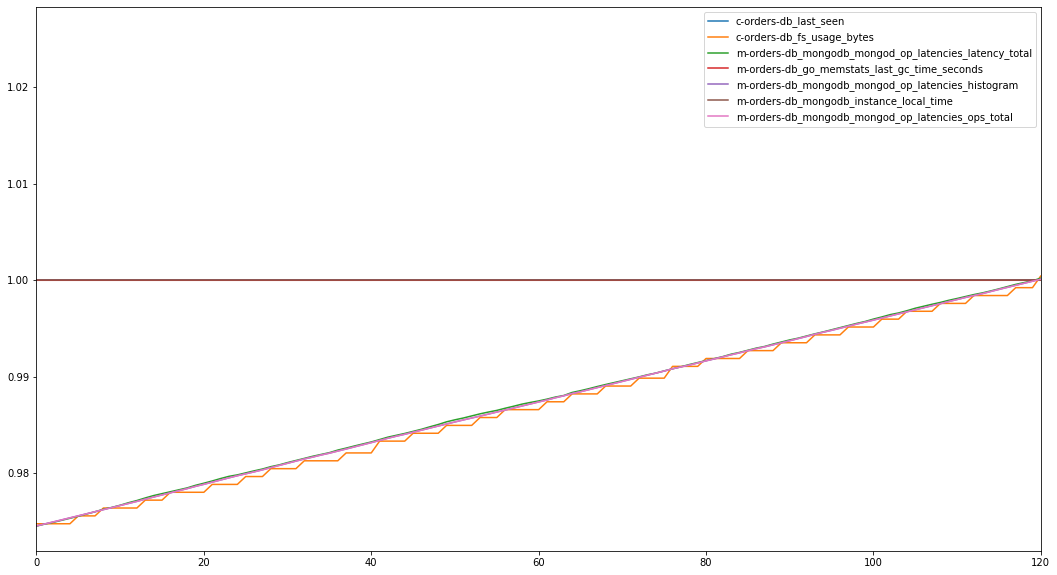

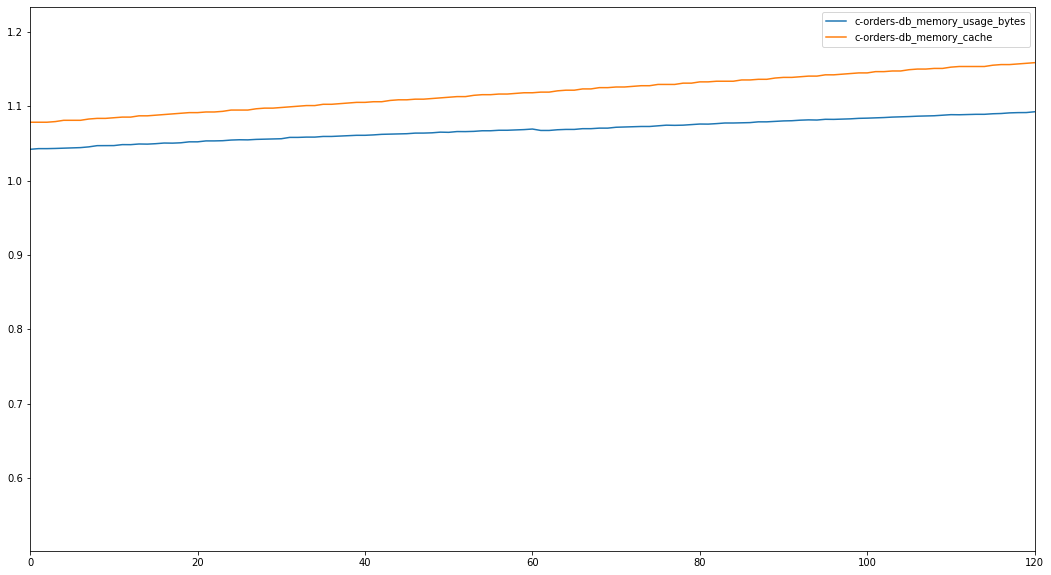

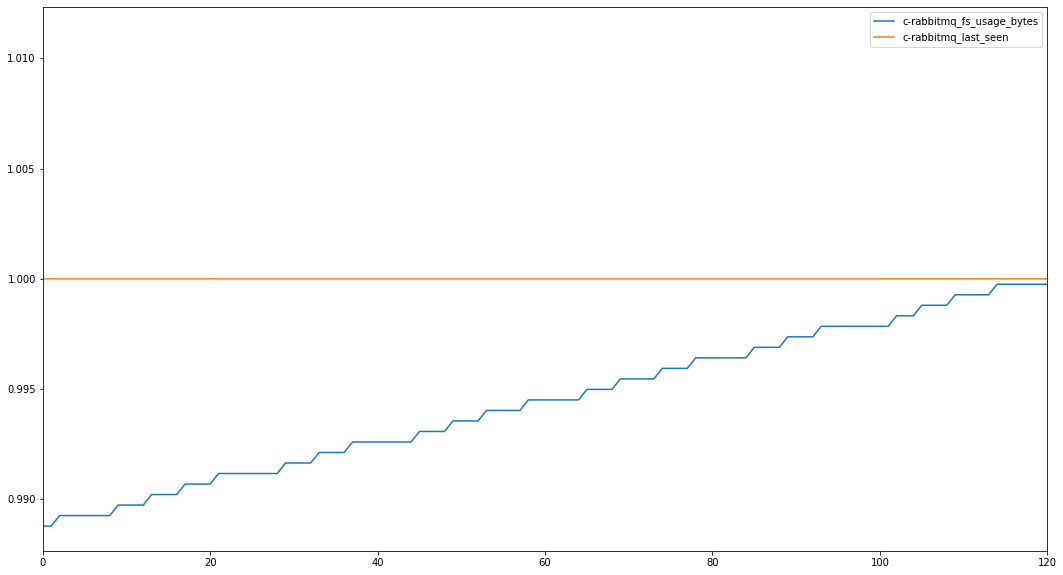

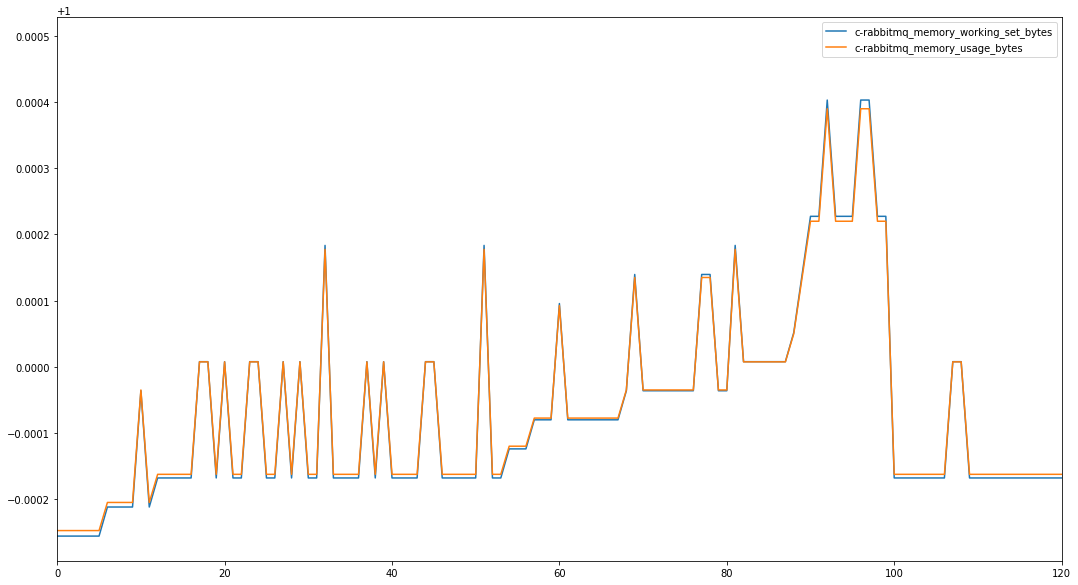

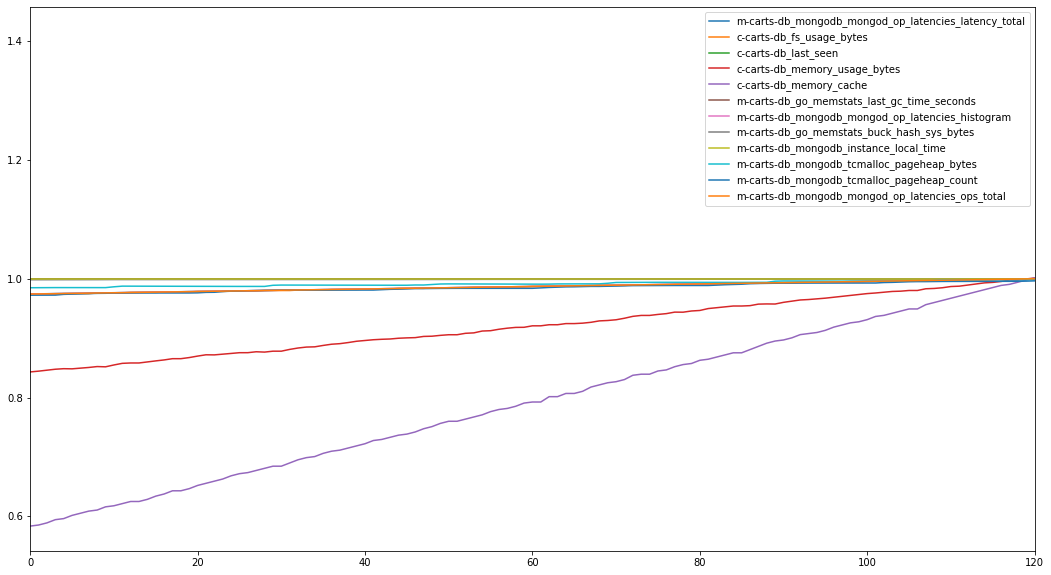

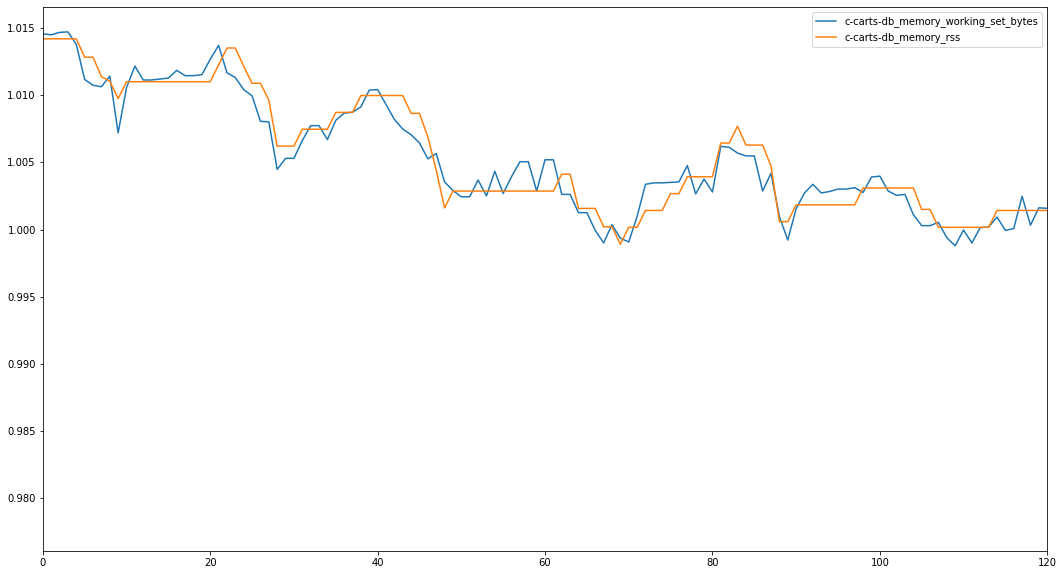

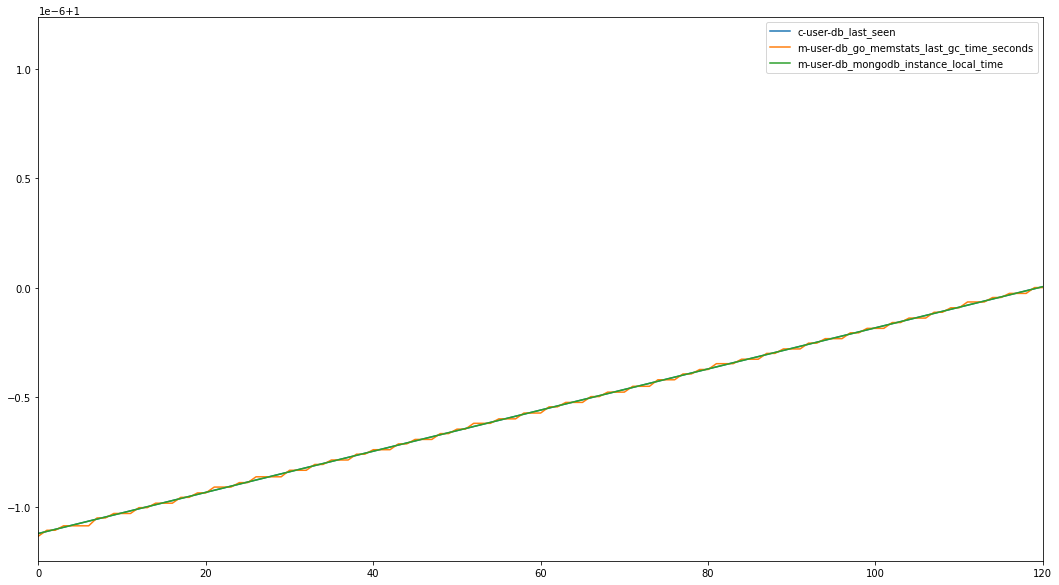

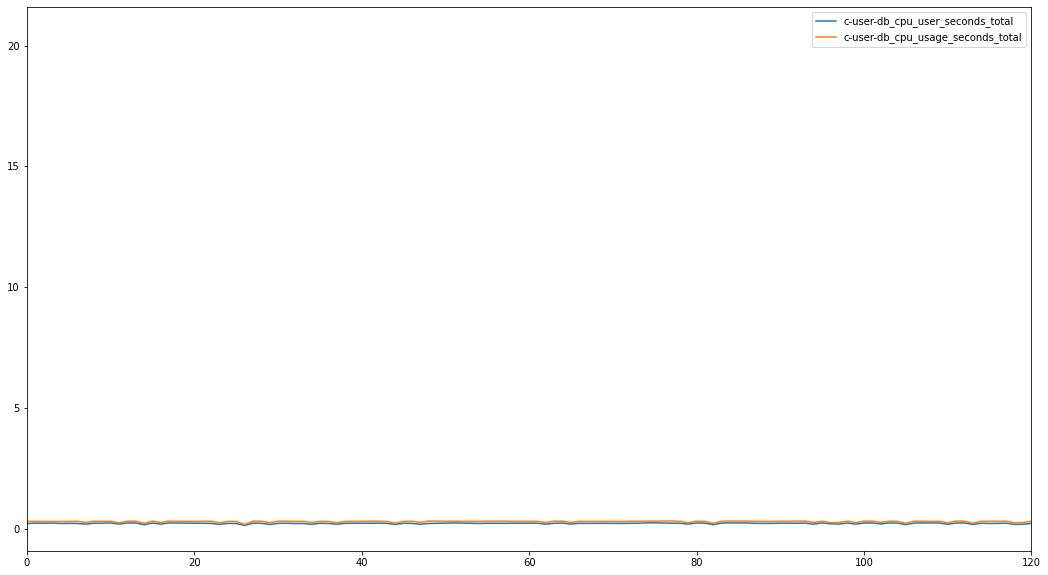

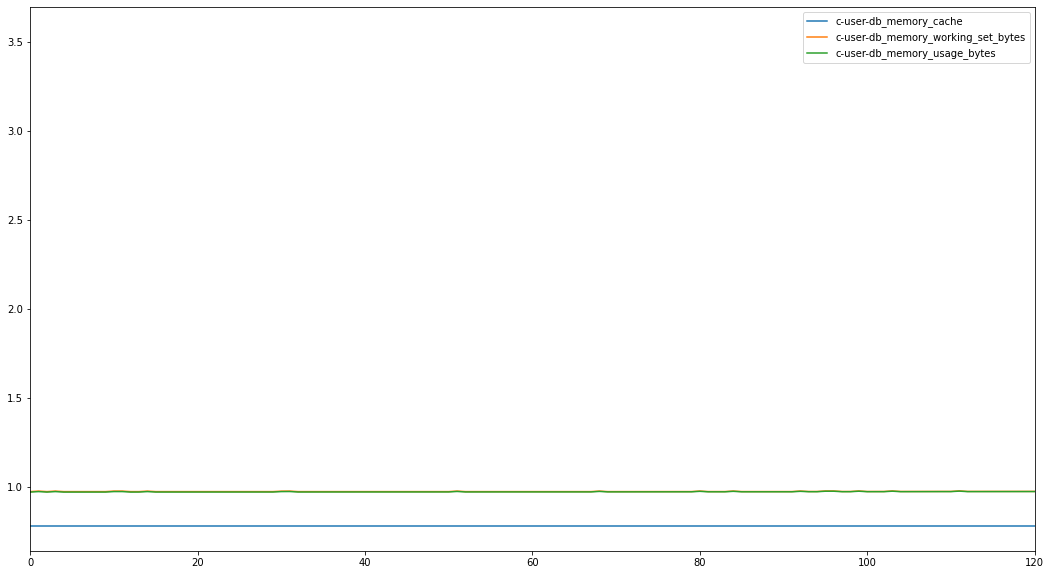

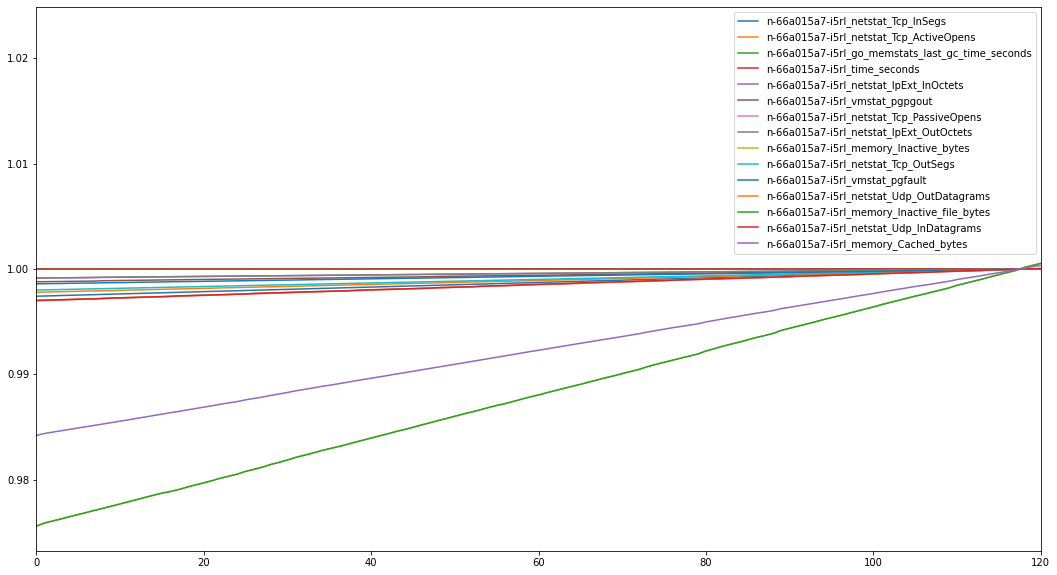

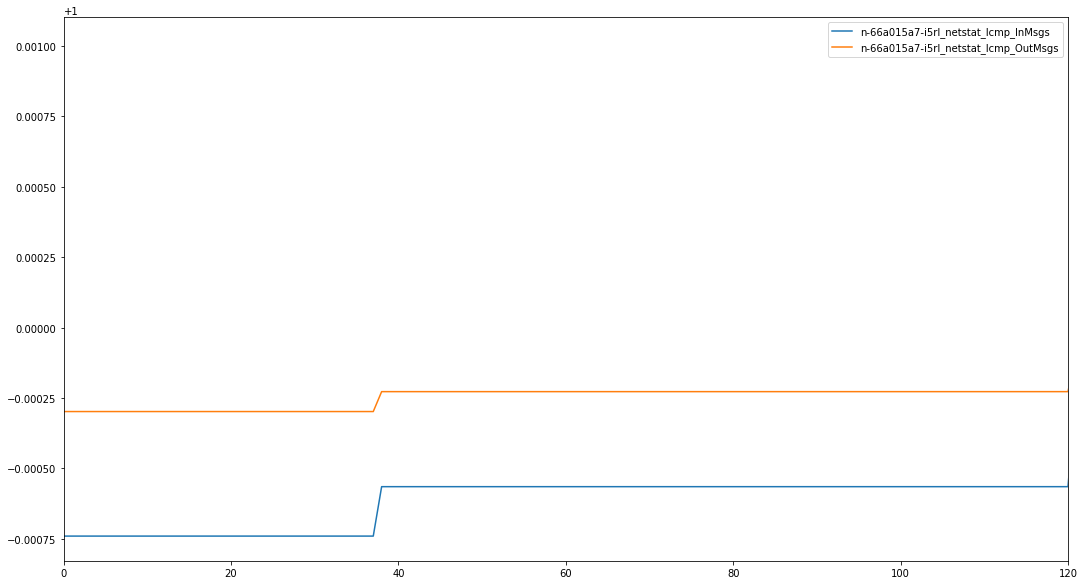

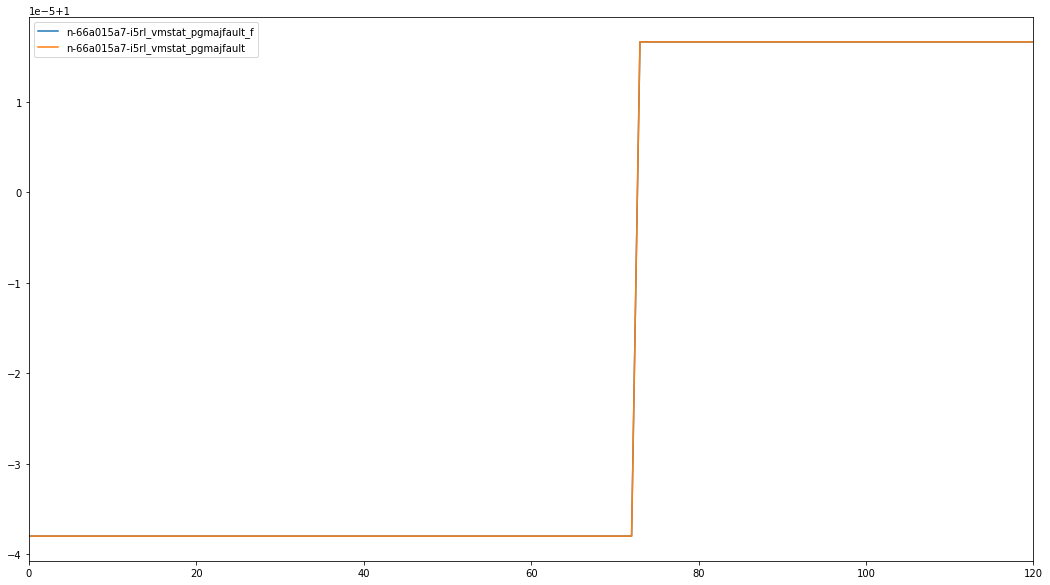

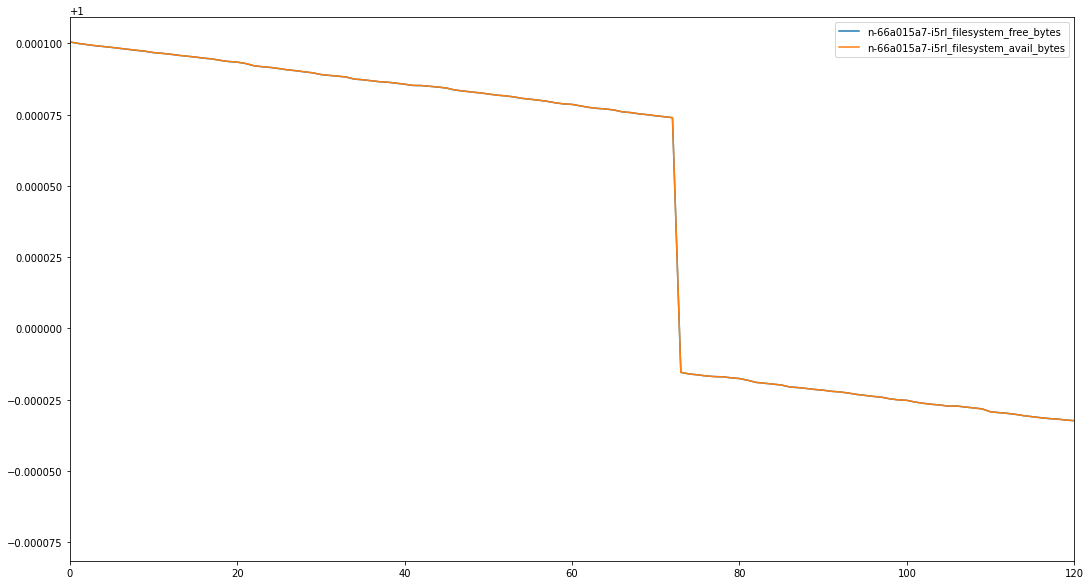

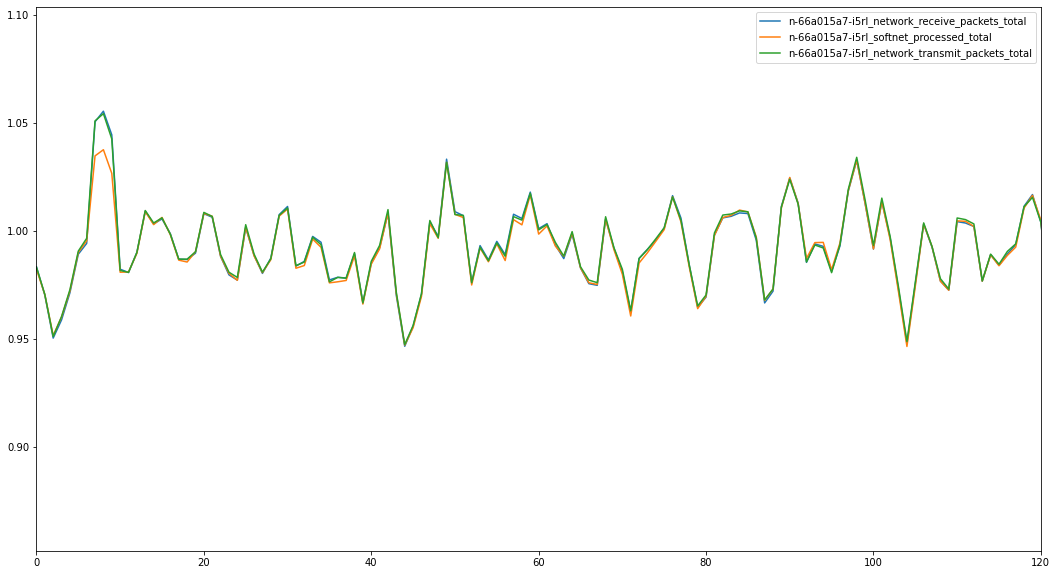

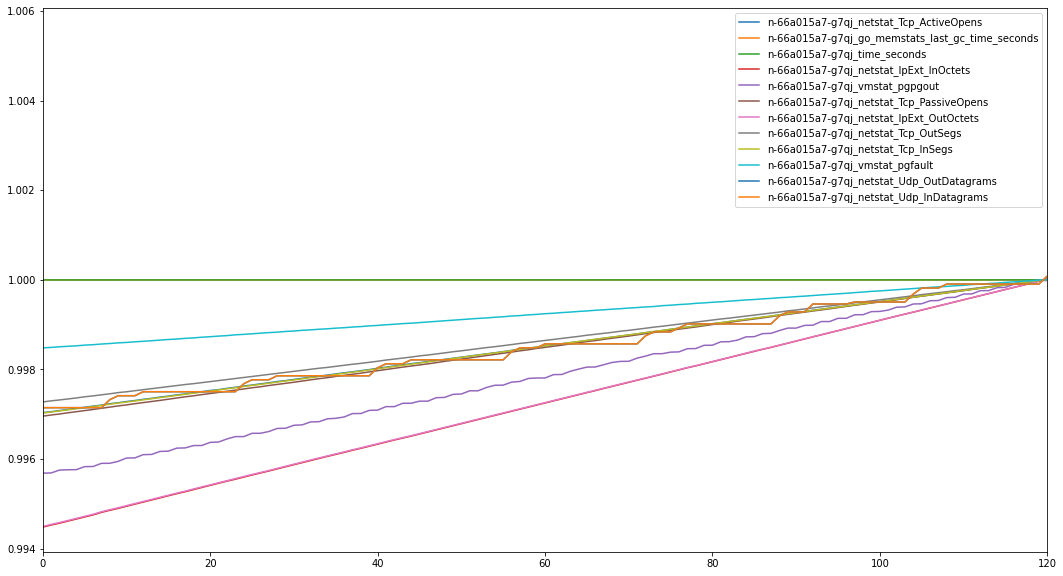

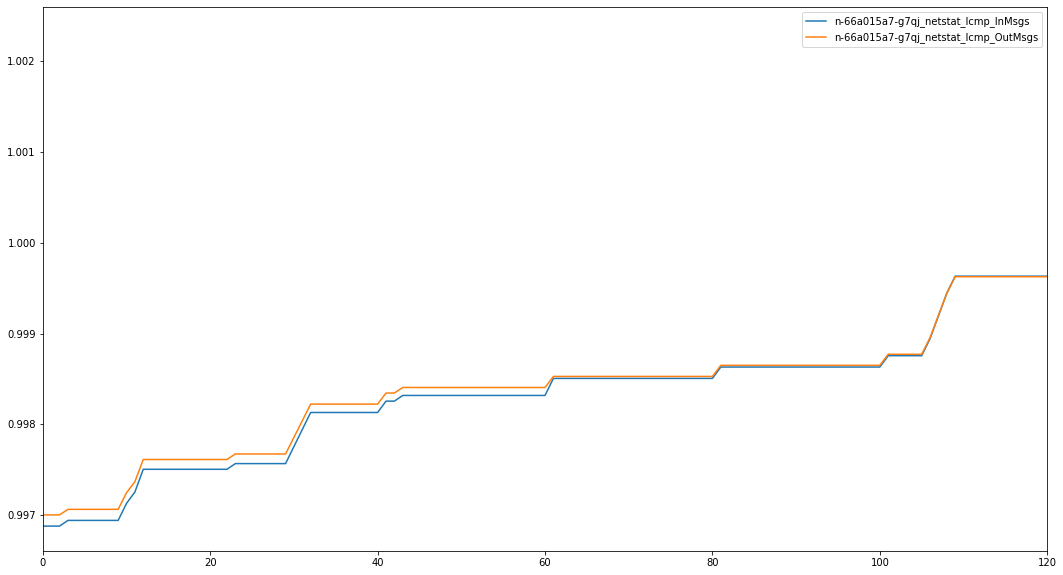

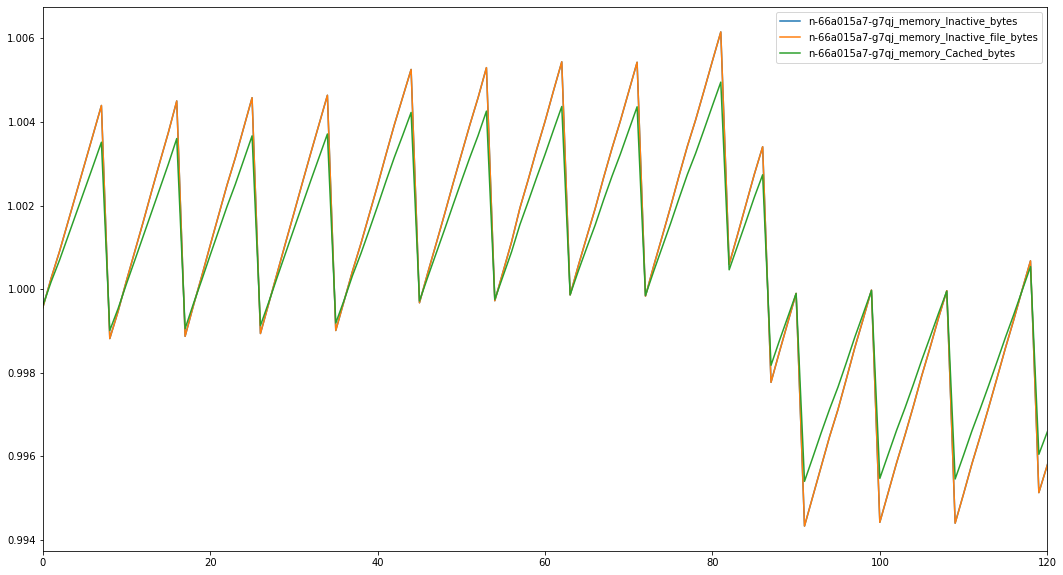

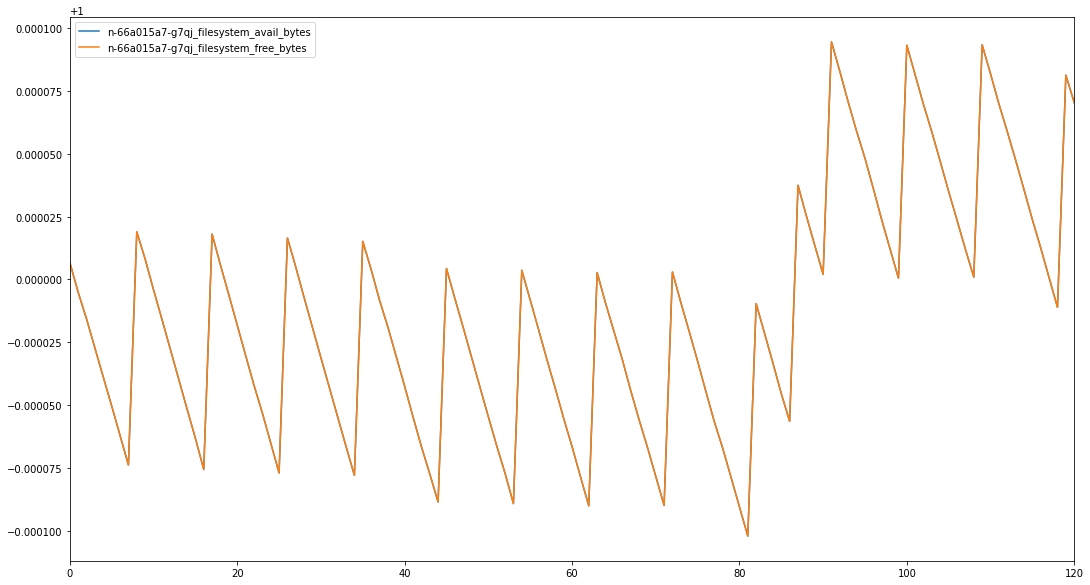

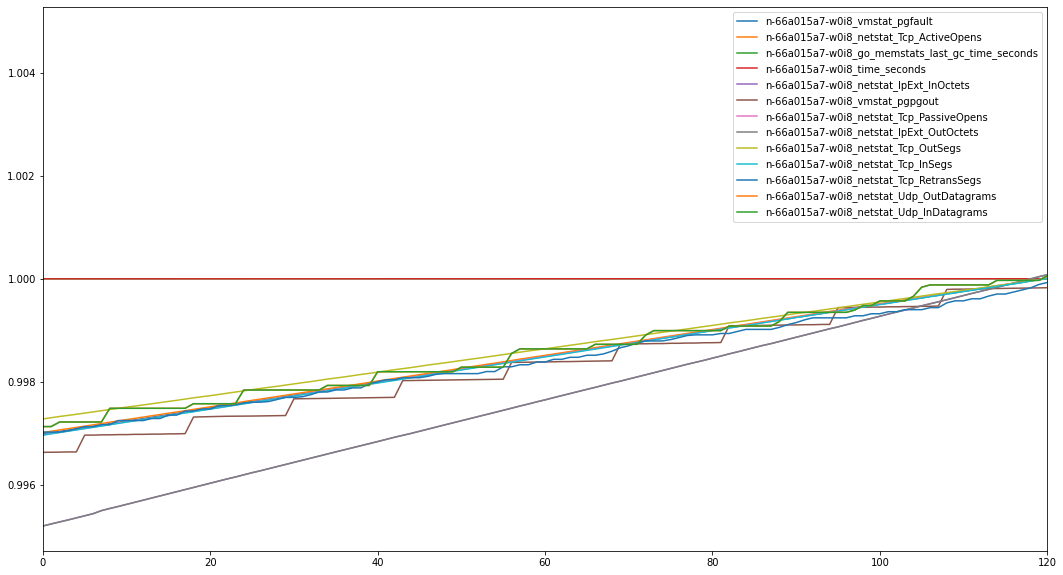

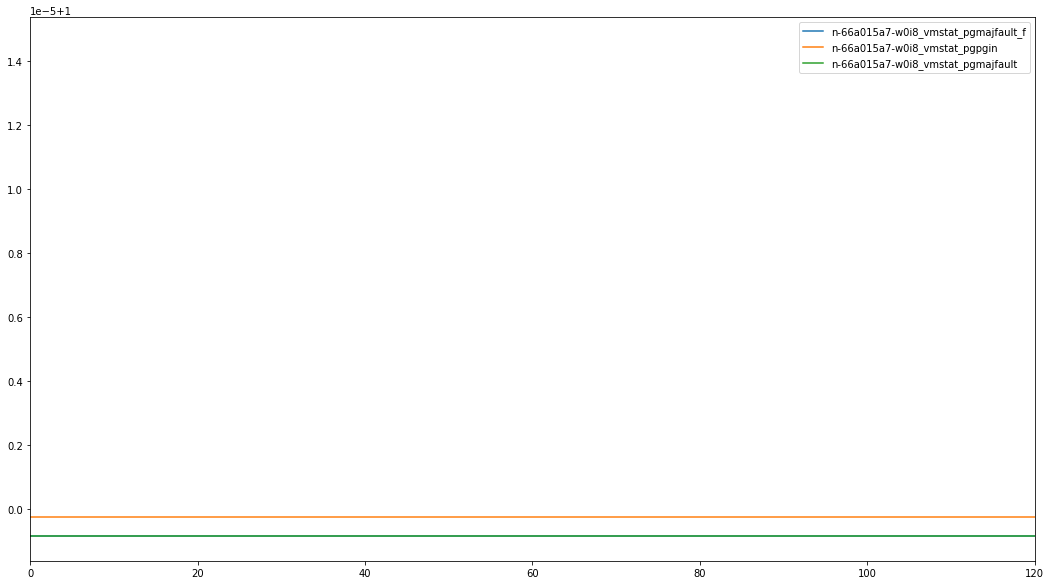

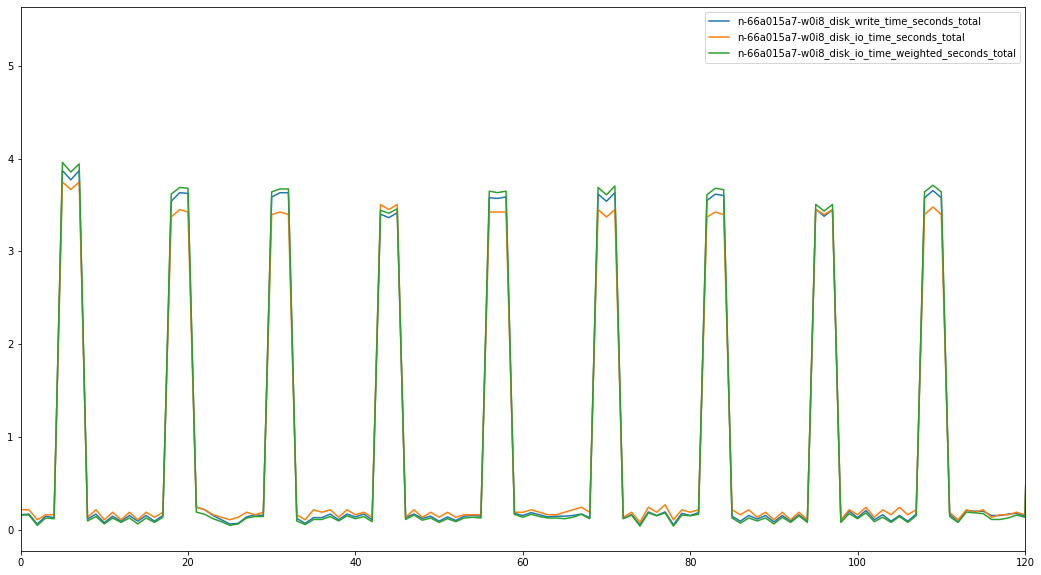

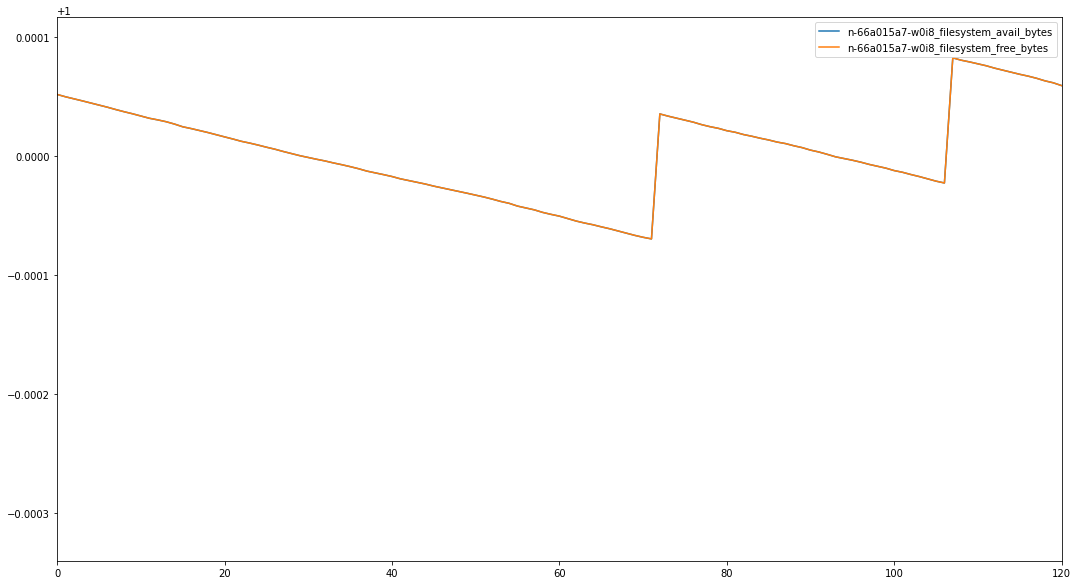

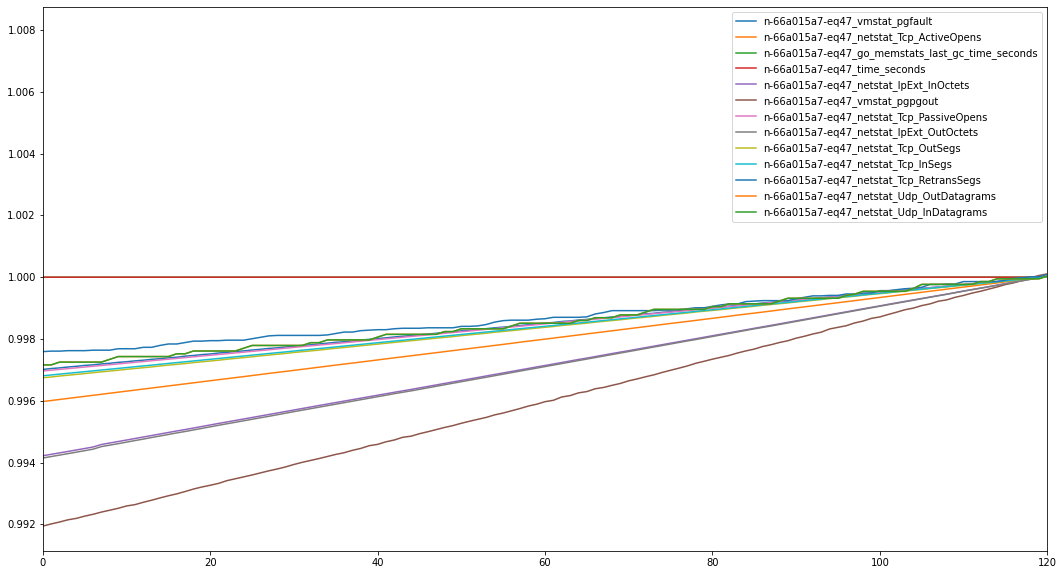

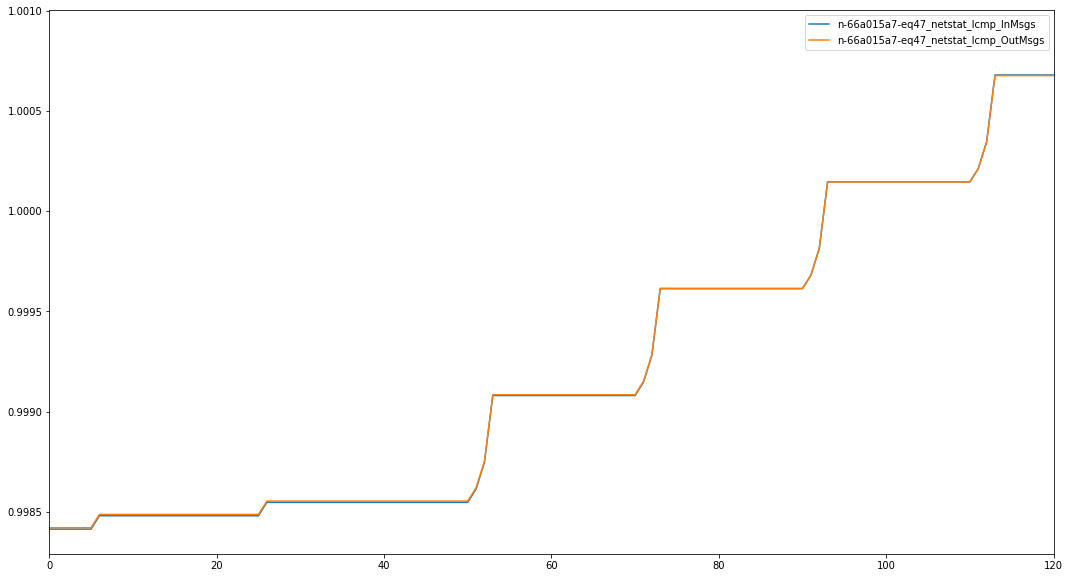

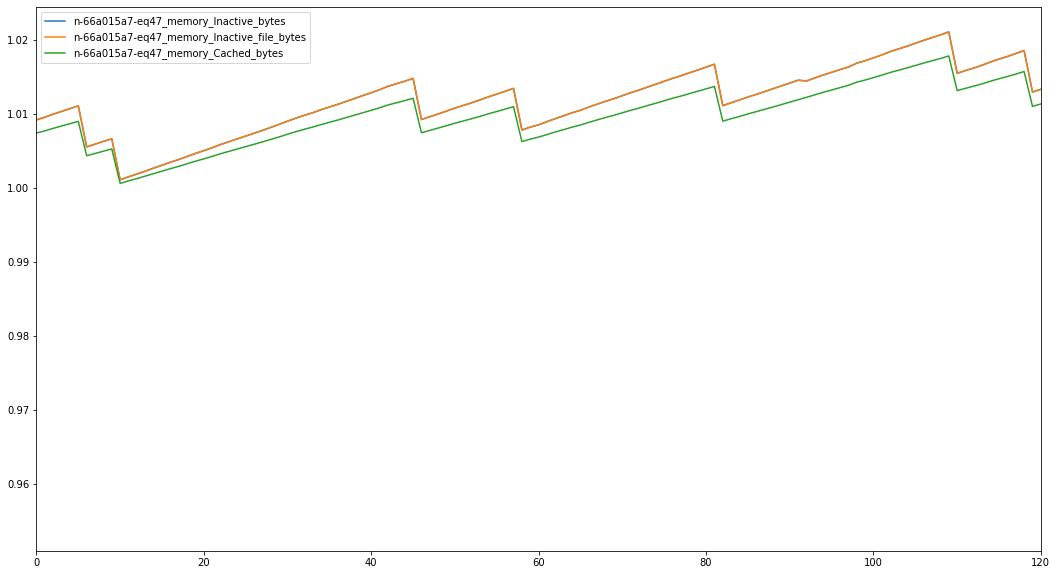

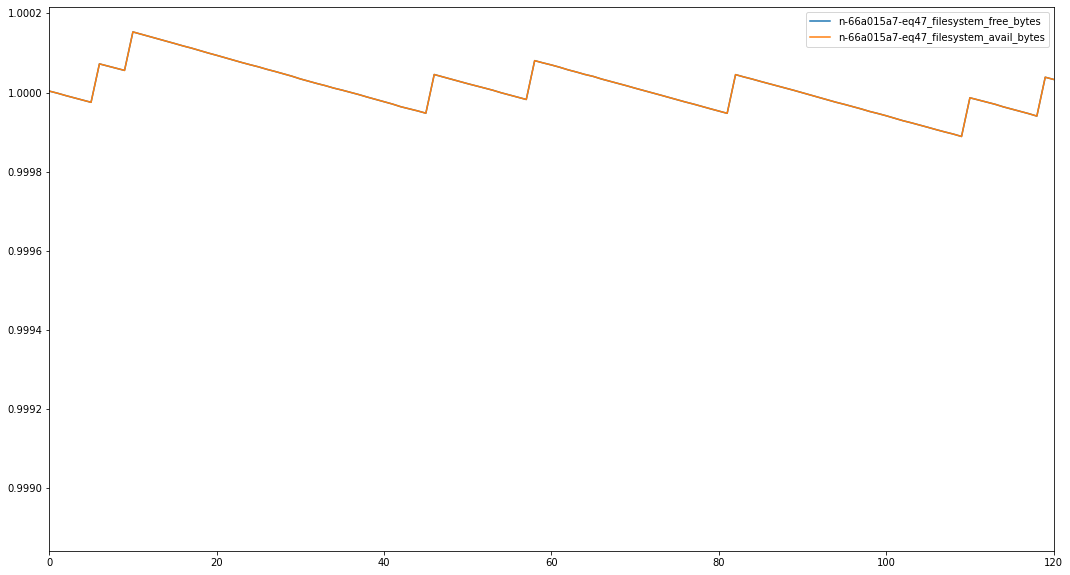

In [91]:
for medoid in clustering_info:
    metric_list = [medoid]
    metric_list.extend(clustering_info[medoid])
    df = pd.DataFrame()
    for m in metric_list:
        df[m] = normalized_df[m]
        #p_val = adfuller(normalized_df[m].values, regression="c")[1]#.round(4)
        #print("{}: {}".format(m, p_val))
    df.plot(figsize=(18, 10), xlim=[0,120])

n-66a015a7-eq47_memory_SReclaimable_bytes: 0.4368
n-66a015a7-eq47_netstat_Tcp_ActiveOpens: 0.9951
n-66a015a7-eq47_netstat_TcpExt_TCPSynRetrans: 0.8852
n-66a015a7-eq47_cpu_seconds_total: 0.7609


<AxesSubplot:>

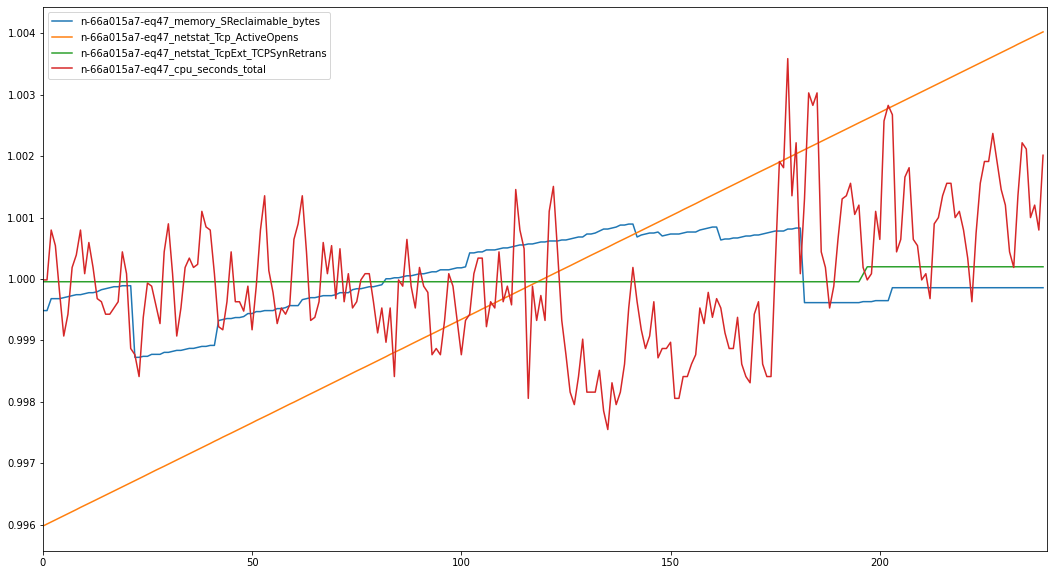

In [49]:
df = pd.DataFrame()
mets = ["n-66a015a7-eq47_memory_SReclaimable_bytes", "n-66a015a7-eq47_netstat_Tcp_ActiveOpens", "n-66a015a7-eq47_netstat_TcpExt_TCPSynRetrans", "n-66a015a7-eq47_cpu_seconds_total"]
for m in mets:
    df[m] = normalized_df[m]
    print("{}: {}".format(m, adfuller(normalized_df[m].values, regression="c")[1].round(4)))
df.plot(figsize=(18, 10), xlim=[0,240])

In [11]:
x = data_df["c-user-db_cpu_user_seconds_total"].values
y = data_df["c-user-db_cpu_usage_seconds_total"].values
dtw(x, y)

4.119699999999999

# ADF検定
・p_valが有意水準より小さい → 単位根であるが棄却され定常過程 → 除外する

In [32]:
series = data_df["n-66a015a7-eq47_netstat_Tcp_ActiveOpens"].values
p_val = adfuller(series)[1]
p_val

0.9951406016965765

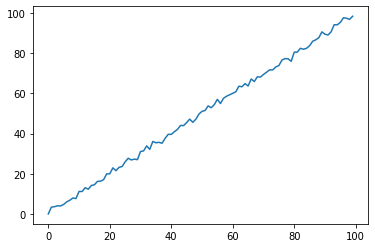

In [35]:
x = np.arange(100)
y = x + np.random.normal(0, 1, size=len(x))
plt.plot(x, y)

In [47]:
p_val = adfuller(y, regression="ct")[1]
p_val

0.010083844601438612

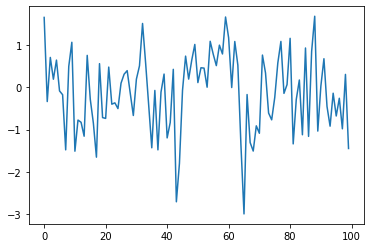

In [37]:
x = np.arange(100)
y = np.random.normal(0, 1, size=len(x))
plt.plot(x, y)

In [38]:
p_val = adfuller(y)[1]
p_val

0.0015421069285832644